In [1]:
import os, sys
from pathlib import Path

src_path = Path(os.getcwd()).resolve().parents[1]  
sys.path.append(str(src_path))

print(sys.path[-1])  
import os
print(os.getcwd())

/Users/seobi/PythonProjects/RAG_Commander/src
/Users/seobi/PythonProjects/RAG_Commander/src/agents/main


In [2]:
%%writefile main_agent.py
from langchain_openai import ChatOpenAI
from langgraph.graph.state import Command, Literal
from agents.state.start_state import StartConfirmation, StartInput
from agents.state.main_state import MainState
from utils.enum import LLMProfile
from utils.util import get_today_str
from langchain_core.messages import HumanMessage, get_buffer_string, AIMessage
from langgraph.graph import StateGraph, START, END
from prompts import PromptManager, PromptType
from agents.analysis.analysis_graph import analysis_graph
from agents.jung_min_jae.jung_min_jae_agent import report_graph
from copy import deepcopy

start_llm = ChatOpenAI(model=LLMProfile.START_COMFIRMATION, temperature=0)
messages_key = MainState.KEY.messages
start_input_key = MainState.KEY.start_input
analysis_outputs_key = MainState.KEY.analysis_outputs
status_key = MainState.KEY.status


def start_confirmation(
    state: MainState,
) -> Command[Literal["start", "__end__"]]:

    parser_llm = start_llm.with_structured_output(StartConfirmation)
    messages_str = get_buffer_string(messages=state[messages_key])

    prompt = PromptManager(PromptType.MAIN_START_CONFIRMATION).get_prompt(
        messages=messages_str
    )
    response: StartConfirmation = parser_llm.invoke([HumanMessage(content=prompt)])

    if response.confirm == False:
        return Command(
            goto=END, update={messages_key: [AIMessage(content=response.question)]}
        )
    else:
        return Command(
            goto="start",
            update={messages_key: [AIMessage(content=response.verification)]},
        )


def start(state: MainState) -> MainState:
    parser_model = start_llm.with_structured_output(StartInput)
    prompt = PromptManager(PromptType.MAIN_START).get_prompt(
        messages=get_buffer_string(state[messages_key]), date=get_today_str()
    )
    response: StartInput = parser_model.invoke([HumanMessage(content=prompt)])
    return {start_input_key: response.model_dump(), status_key: "ANALYSIS"}


def analysis_graph_node(state: MainState) -> MainState:
    result = analysis_graph.invoke({"start_input": deepcopy(state[start_input_key])})
    return {
        "analysis_outputs": result.get("analysis_outputs", {}),
        status_key: "JUNG_MIN_JAE"
    }


def jung_min_jae_graph(state: MainState) -> MainState:
    result = report_graph.invoke({"start_input": deepcopy(state[start_input_key]),
                                  "analysis_outputs": deepcopy(state[analysis_outputs_key])})
    return {
        "final_report": result["final_report"],
        status_key:"RENDERING"
    }


graph_builder = StateGraph(MainState)

start_confirmation_key = "start_confirmation"
start_key = "start"
analysis_graph_key = "analysis_graph"
jung_min_jae_key = "jung_min_jae_graph"

graph_builder.add_node(start_confirmation_key, start_confirmation)
graph_builder.add_node(start_key, start)
graph_builder.add_node(analysis_graph_key, analysis_graph_node)
graph_builder.add_node(jung_min_jae_key, jung_min_jae_graph)

graph_builder.add_edge(START, start_confirmation_key)
graph_builder.add_edge(start_key, analysis_graph_key)
graph_builder.add_edge(analysis_graph_key, jung_min_jae_key)
graph_builder.add_edge(analysis_graph_key, END)


Overwriting main_agent.py


/Users/seobi/PythonProjects/RAG_Commander/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


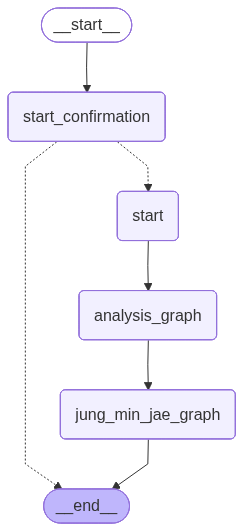

In [3]:
from main_agent import graph_builder
graph = graph_builder.compile()
graph

In [4]:
from utils.format_message import format_message
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import InMemorySaver
from agents.state.main_state import MainState
messages_key = MainState.KEY.messages
checkpointer = InMemorySaver()
graph = graph_builder.compile(checkpointer = checkpointer)

thread = {"configurable": {"thread_id":"1"}}
result = graph.invoke(
    {
        messages_key : [HumanMessage(content = "경기도 분당구 정자동 백현로 206 근처를 분석하고 싶고 규모는 대단지, 세대수는 1000세대 정도 생각합니다. ")]
    },
    config = thread
)

format_message(result[messages_key])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 경기도 분당구 정자동 백현로 206 근처를 분석하고 싶고 규모는 대단지, 세대수는 1000세대 정도 생각합니다.          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 보고서 작성을 시작하겠습니다. 요청하신 내용은 경기도 분당구 정자동 백현로 206 근처의 대단지 아파트로, 약        │
│ 1000세대 규모임을 확인하였습니다. 해당 정보를 바탕으로 분석을 진행하겠습니다.                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [5]:
result

{'messages': [HumanMessage(content='경기도 분당구 정자동 백현로 206 근처를 분석하고 싶고 규모는 대단지, 세대수는 1000세대 정도 생각합니다. ', additional_kwargs={}, response_metadata={}, id='07b92c7b-8765-4f34-ba10-4d4256df4c6a'),
  AIMessage(content='보고서 작성을 시작하겠습니다. 요청하신 내용은 경기도 분당구 정자동 백현로 206 근처의 대단지 아파트로, 약 1000세대 규모임을 확인하였습니다. 해당 정보를 바탕으로 분석을 진행하겠습니다.', additional_kwargs={}, response_metadata={}, id='4940ef21-5c5d-4de0-bed7-85cac04552f8')],
 'start_input': {'target_area': '경기도 분당구 정자동 백현로 206 근처',
  'scale': '대단지',
  'total_units': 1000,
  'units_by_type': None,
  'brand': None,
  'orientation': None,
  'parking_ratio': None,
  'terrain_condition': None,
  'gross_area': None,
  'floor_area_ratio_range': None,
  'building_coverage_ratio_range': None},
 'analysis_outputs': {'economic_insight': '{\n  "spec_version": "1.0.0",\n  "generated_at": "2025-10-26T10:00:00+09:00",\n  "agent": "EconomicInsightAgent",\n  "ok": true,\n\n  "facts": {\n    "meta": {\n      "target_area": "경기도 분당구 정자동 백현로 206 인근",\n      "date": "2025-10

In [6]:
print(result['final_report'])

# 0. 표지 요약 (Executive Summary)

본 사업은 2024-04 기준, 인근 1km 내 유사 연식·평형 매매 평단가 1,200만원/3.3㎡ 대비 ±10% 범위 내에서 권장 분양가 밴드를 1,080~1,320만원/3.3㎡로 산출하였습니다. 수요 측면에서 평균 경쟁률 2.5배, 1순위 마감률 75%로 양호한 흡수력을 보이며, 순유입 인구도 +0.15%p로 긍정적입니다. 다만, 미분양 위험은 최근 5년 밴드 상단 가격대와 준공 후 미분양 증가 추세로 중간 수준으로 평가됩니다. 가격 리스크는 분양가가 인근 시세 대비 +8% 수준으로 보수적이나, 브랜드 및 역세권 프리미엄을 반영한 결과입니다. 단기적으로는 무이자 할부 및 계약금 완화 전략을 병행하여 분양성 제고가 필요합니다.

# 1. 사업환경 분석 (입지/생활권/호재)

사업지는 서울 강남구 중심부에서 도보 8분 거리에 위치하며, 역세권 프리미엄이 기대됩니다. 주변 학군은 우수 학원가와 인접해 있어 교육 수요가 높고, 생활 편의시설도 반경 500m 내에 다수 분포합니다. 최근 도시재생 사업과 교통 인프라 확충 계획이 발표되어 중장기 가치 상승 요인이 존재합니다. 이러한 입지적 강점은 분양가 프리미엄 산정과 수요 확보에 긍정적 영향을 미칩니다.

# 2. 사업개요 (요약 표)

| 위치          | 서울 강남구 역삼동           |
|---------------|-----------------------------|
| 규모          | 1개 동, 150세대             |
| 브랜드        | 프리미엄 A 브랜드            |
| 용적률        | 250%                        |
| 주력 평형     | 84㎡ (전용면적 기준)         |
| 기준일        | 2024-04                    |

# 3. 수요타겟 분석

수요는 30~40대 직장인 및 학령기 자녀를 둔 가족이 주를 이루며, 평균 경쟁